In [1]:
import numpy as np
from scipy import sparse
from scipy import linalg as la
from matplotlib import pyplot as plt

import rom_operator_inference as roi

In [2]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["text.usetex"] = True
np.random.seed(10)

# ROM Operator Inference Example: One-dimensional Heat Equation

This example is based on the operator inference problem for the 1D heat equation described in the following paper, with some small changes in notation.

> Peherstorfer, B. and Willcox, K.
[Data-driven operator inference for non-intrusive projection-based model reduction.](https://www.sciencedirect.com/science/article/pii/S0045782516301104)
Computer Methods in Applied Mechanics and Engineering, 306:196-215, 2016.
([Download](https://cims.nyu.edu/~pehersto/preprints/Non-intrusive-model-reduction-Peherstorfer-Willcox.pdf))<details><summary>BibTeX</summary><pre>
@article{Peherstorfer16DataDriven,
    title     = {Data-driven operator inference for nonintrusive projection-based model reduction},
    author    = {Peherstorfer, B. and Willcox, K.},
    journal   = {Computer Methods in Applied Mechanics and Engineering},
    volume    = {306},
    pages     = {196--215},
    year      = {2016},
    publisher = {Elsevier}
}</pre></details>

## Problem Statement (non-parametric)

Let $\Omega = [0,L]\subset \mathbb{R}$ be the spatial domain indicated by the variable $\omega$, and let $[0,T]\subset\mathbb{R}$ be the time domain with variable $t$.
We consider the one-dimensional heat equation with non-homogeneous Dirichlet boundary conditions,
$$
\begin{align*}
    \frac{\partial}{\partial t} x(\omega,t) - \frac{\partial^2}{\partial\omega^2}x(\omega,t) &= 0
    & \omega &\in\Omega,\quad t\in[0,T],
    \\
    x(0,t) = x(L,t) &= u(t)
    & t &\in[0,T],
    \\
    x(\omega,0) = e^{\alpha(\omega - 1)} + e^{-\alpha\omega} &- e^{-\alpha}
    & \omega &\in \Omega.
\end{align*}
$$

Let $\{\omega_i\}_{i=0}^{n+1}$ be an equidistant grid of $n+2$ points on $\Omega$, i.e.,
$$
\begin{align*}
    0 &= \omega_0 < \omega_1 < \cdots < \omega_n < \omega_{n+1} = L
    &
    &\text{and}
    &
    \delta\omega &= \frac{L}{n+1} = \omega_{i+1} - \omega_{i},\quad i=1,\ldots,n-1.
\end{align*}
$$
Since the boundary conditions prescribe $x(\omega_0,t) = x(\omega_{n+1},t) = 1$, we wish to compute the state vector $\mathbf{x}(t) = \begin{bmatrix} x(\omega_1,t) & \cdots & x(\omega_n,t)\end{bmatrix}^\mathsf{T}\in\mathbb{R}^n$ for various $t\in[0,T]$.

Introducing the finite difference approximation
$$
\begin{align*}
    \frac{\partial^2}{\partial\omega^2}x(\omega,t) &\approx \frac{x(\omega-\delta\omega,t) - 2x(\omega,t) + x(\omega+\delta\omega,t)}{(\delta\omega)^2}
    % &
    % \Longrightarrow&
    % &
    % \frac{\partial^2}{\partial\omega^2}x(\omega_i,t) &\approx \frac{x(\omega_{i-1},t) - 2x(\omega_{i},t) + x(\omega_{i+1},t)}{(\delta\omega)^2}
    % \\
    &
    &\Longrightarrow
    &
    \frac{\partial^2}{\partial\omega^2}x_{i} &\approx \frac{x_{i-1} - 2x_{i} + x_{i+1}}{(\delta\omega)^2},
\end{align*}
$$
we obtain the semi-discrete linear system
$$
\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t) + Bu(t),
$$
where
$$
\begin{align*}
    A &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{ccccc}
        -2 & 1 & & & \\
        1 & -2 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & 1 & -2 & 1 \\
        & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    B &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{c}
        1 \\ 0 \\ \vdots \\ 0 \\ 1
    \end{array}\right]\in\mathbb{R}^{n}.
\end{align*}
$$

### Snapshot Data Generation

For simplicity, let $L = T = 1$ and $u(t) = 1$.
We begin by simulating the full-order system described above with a maximal time step size $\delta t = 10^{-3}$, resulting in $k = 10^3+1$ time steps (1000 steps past the initial condition).
The result is the snapshot matrix $X\in\mathbb{R}^{n\times k}$, where the $j$th column is the solution trajectory at time $t_j$.
We also compute the derivative at each snapshot, obtaining $\dot{X}\in\mathbb{R}^{n\times k}$.

In [3]:
# Construct the spatial domain.
W = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
w_all = np.linspace(0, W, n+2)  # Full spatial grid.
w = w_all[1:-1]                 # Interior spatial grid (where x is unknown).
dw = w[1] - w[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
k = T*10**3 + 1                 # Temporal grid size.
t = np.linspace(0, T, k)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size dw = {dw}")
print(f"Temporal step size dt = {dt}")

Spatial step size dw = 0.0078125
Temporal step size dt = 0.001


In [4]:
# Construct state matrix A.
dw2inv = 1 / dw**2
diags = np.array([1, -2, 1]) * dw2inv
A = sparse.diags(diags, [-1,0,1], (n,n))

# Construct input matrix B.
B = np.zeros_like(w)
B[0], B[-1] = dw2inv, dw2inv
u = lambda t: np.ones_like(t)   # Input function u(t) = 1.
U = u(t)                        # Inputs over the time domain.

# Construct the initial condition.
alpha = 100
x0 = np.exp(alpha*(w-1)) + np.exp(-alpha*w) - np.exp(-alpha)

print(f"shape of A:\t{A.shape}")
print(f"shape of B:\t{B.shape}")
print(f"shape of x0:\t{x0.shape}")

shape of A:	(127, 127)
shape of B:	(127,)
shape of x0:	(127,)


Since this is a diffusive problem, we will use the Implicit (Backward) Euler method for solving the ODEs.
The method is defined by
$$
    \mathbf{x}_{k+1} = \mathbf{x}_{k} + \delta t f(t_{k+1},\mathbf{x}_{k+1},u_{k+1}).
$$
With the form $f(t,\mathbf{x}(t),u(t)) = A\mathbf{x}(t) + Bu(t)$, this becomes
$$
    \mathbf{x}_{k+1} = (I - \delta t A)^{-1}\left(\mathbf{x}_{k} + \delta t B u(t_{k+1})\right).
$$

In [5]:
def implicit_euler(t, x0, A, B, U):
    """Solve the system
    
        dx / dt = Ax(t) + Bu(t),    x(0) = x0,
    
    over a uniform time domain via the Implicit Euler method.
    
    Parameters
    ----------
    t : (k,) ndarray
        Uniform time array over which to solve the ODE.
    
    x0 : (n,) ndarray
        Initial condition.
    
    A : (n,n) ndarray
        State matrix.
    
    B : (n,) or (n,1) ndarray
        Input matrix.
    
    U : (k,) ndarray
        Inputs over the time array.
    
    Returns
    -------
    x : (n,k) ndarray
        Solution to the ODE at time t; that is, x[:,j] is the
        computed solution corresponding to time t[j].
    """
    # Check and store dimensions.
    k = len(t)
    n = len(x0)
    B = np.ravel(B)
    assert A.shape == (n,n)
    assert B.shape == (n,)
    assert U.shape == (k,)
    I = np.eye(n)

    # Check that the time step is uniform.
    dt = t[1] - t[0]
    assert np.allclose(np.diff(t), dt)

    # Factor I - dt*A for quick solving at each time step.
    factored = la.lu_factor(I - dt*A)

    # Solve the problem at each time step.
    x = np.empty((n,k))
    x[:,0] = x0.copy()
    for i in range(1,k):
        x[:,i] = la.lu_solve(factored, x[:,i-1] + dt*B*U[i])

    return x

In [6]:
# Compute snapshots by solving the equation with implicit_euler().
X = implicit_euler(t, x0, A, B, U)

# Also compute velocities (dx/dt) at each snapshot.
Xdot = A @ X + B.reshape((-1,1))*U

print(f"shape of X:\t{X.shape}")
print(f"shape of Xdot:\t{Xdot.shape}")

shape of X:	(127, 1001)
shape of Xdot:	(127, 1001)


Finally, we visualize the snapshots to get a sense of how the solution looks qualitatively.

In [7]:
def plot_heat_data(Z, title="Snapshot Data"):
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,4))

    # Plot a few snapshots.
    color = iter(plt.cm.viridis(np.linspace(.25, 1, 5)))
    for j in [0, 20, 80, 160, 640]:
        x_all = np.concatenate([[1], Z[:,j], [1]])  # Pad with boundary conditions.
        ax1.plot(w_all, x_all, color=next(color), label=rf"$x(\omega,t_{{{j}}})$")
    ax1.set_xlim(0, 1)
    ax1.set_xlabel(r"Space $\omega$")
    ax1.set_ylabel(r"$x(\omega,t)$")
    ax1.legend(loc="lower right", fontsize=8, bbox_to_anchor=(1.01,.05))

    # Plot all snapshots in space and time.
    ww, tt = np.meshgrid(w, t)
    cdata = ax2.pcolormesh(ww, tt, Z.T, cmap="magma")
    plt.colorbar(cdata, ax=ax2, extend="both")
    ax2.set_xlabel(r"Space $\omega$")
    ax2.set_ylabel(r"Time $t$")

    fig.suptitle(title)
    plt.show()

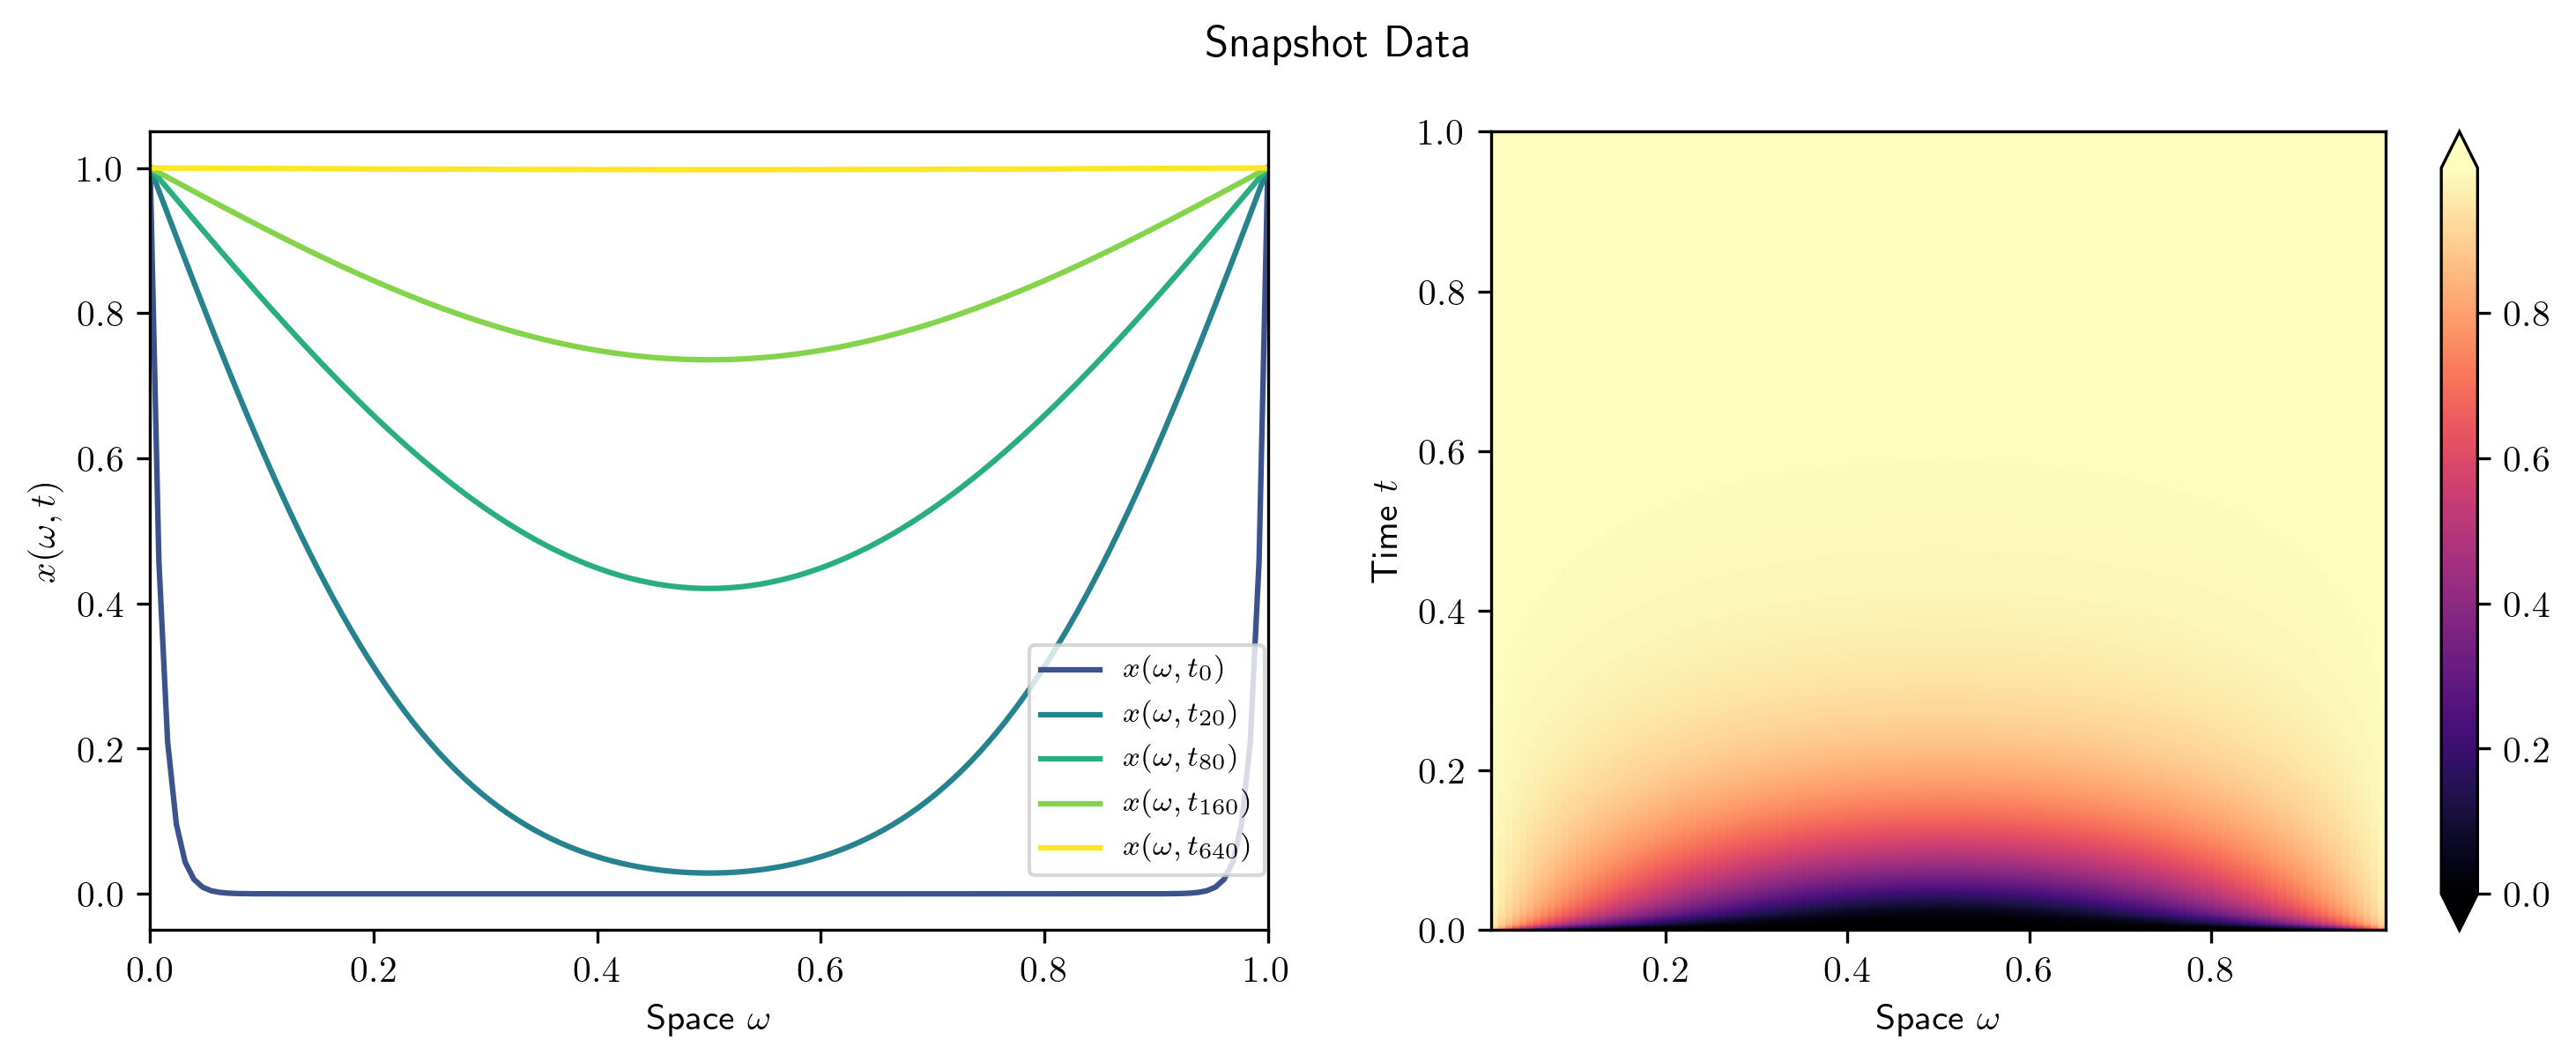

In [8]:
plot_heat_data(X)

### Reduced Model Construction

Now that we have snapshot data $X$, we can construct a POD basis $V_r$ to use in the construction of the ROM.
There are a few ways to make an informed choice of $r$; in this example, we examine the _projection error_, defined by
$$
\text{err}_\text{projection} = \frac{||X - V_rV_r^\mathsf{T}X||_F}{||X||_F}.
$$
We choose $r$ so that the projection error is under $10^{-5}$.

8

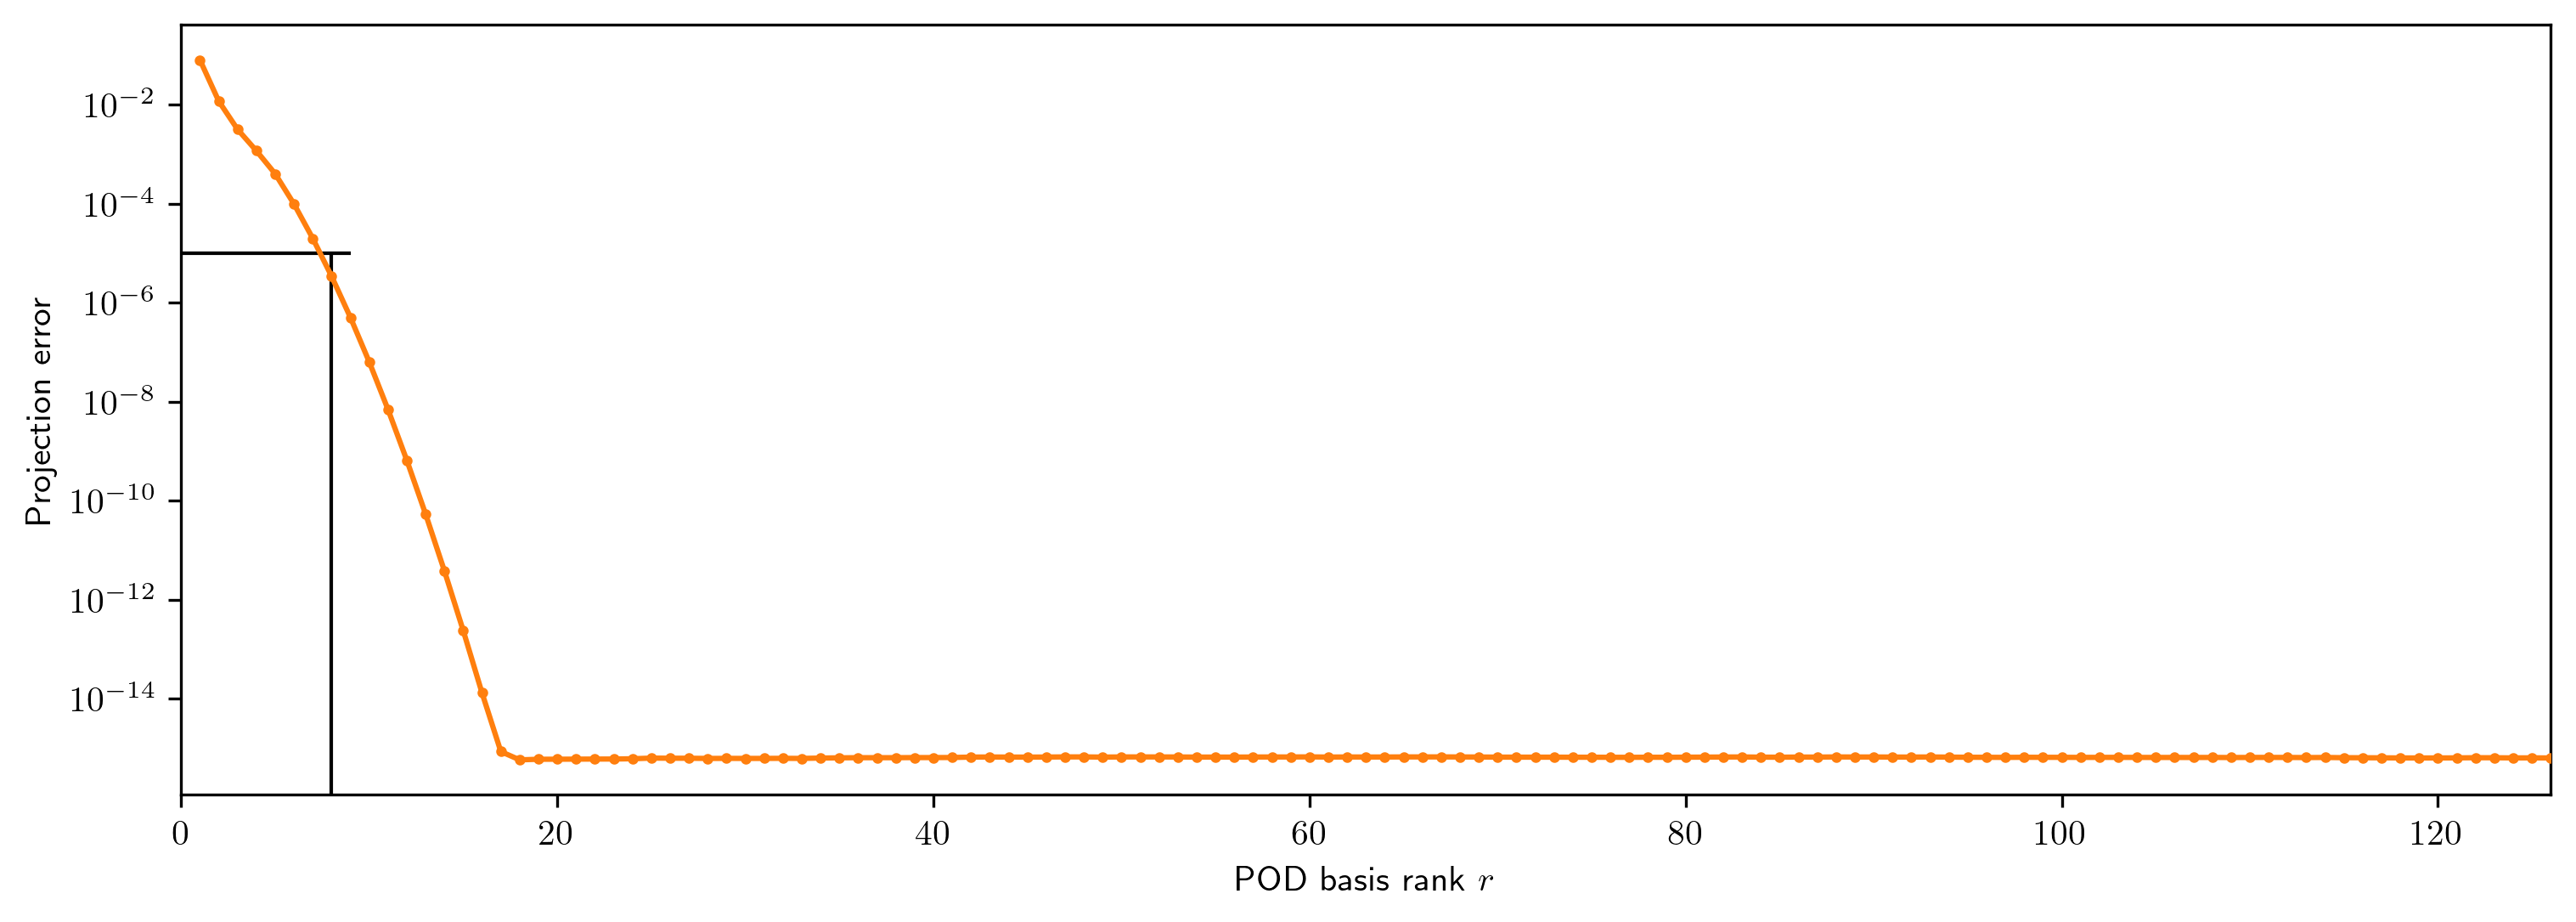

In [9]:
roi.pre.minimal_projection_error(X, eps=1e-5, plot=True)

In [10]:
Vr = roi.pre.pod_basis(X, r=8)
roi.pre.projection_error(X, Vr)

3.4317809998239133e-06

Now we can learn the reduced model with operator inference.
Because the full-order model is of the form $\dot{\mathbf{x}}(t) = A\mathbf{x}(t) + Bu(t)$, we specify a reduced model form of $\dot{\hat{\mathbf{x}}}(t) = \hat{A}\hat{\mathbf{x}}(t) + \hat{B}u(t)$ (`modelform="AB"`).

In [11]:
# Train and run the model.
inferred_model = roi.InferredContinuousROM(modelform="AB")
inferred_model.fit(X, Xdot, Vr, U)
x0_ = Vr.T @ x0                                     # Project the initial condition.
X_ROM_inferred = Vr @ implicit_euler(t, x0_, inferred_model.A_, inferred_model.B_, U)

For the error analysis, since we used the projection error to determine $r$, we use a similar measure to evaluate the state error:
$$
\text{err}_\text{state} = \frac{||X - X_\text{ROM}||_F}{||X||_F}.
$$

In [12]:
roi.post.frobenius_error(X, X_ROM_inferred)[1]

3.4871149565038813e-06

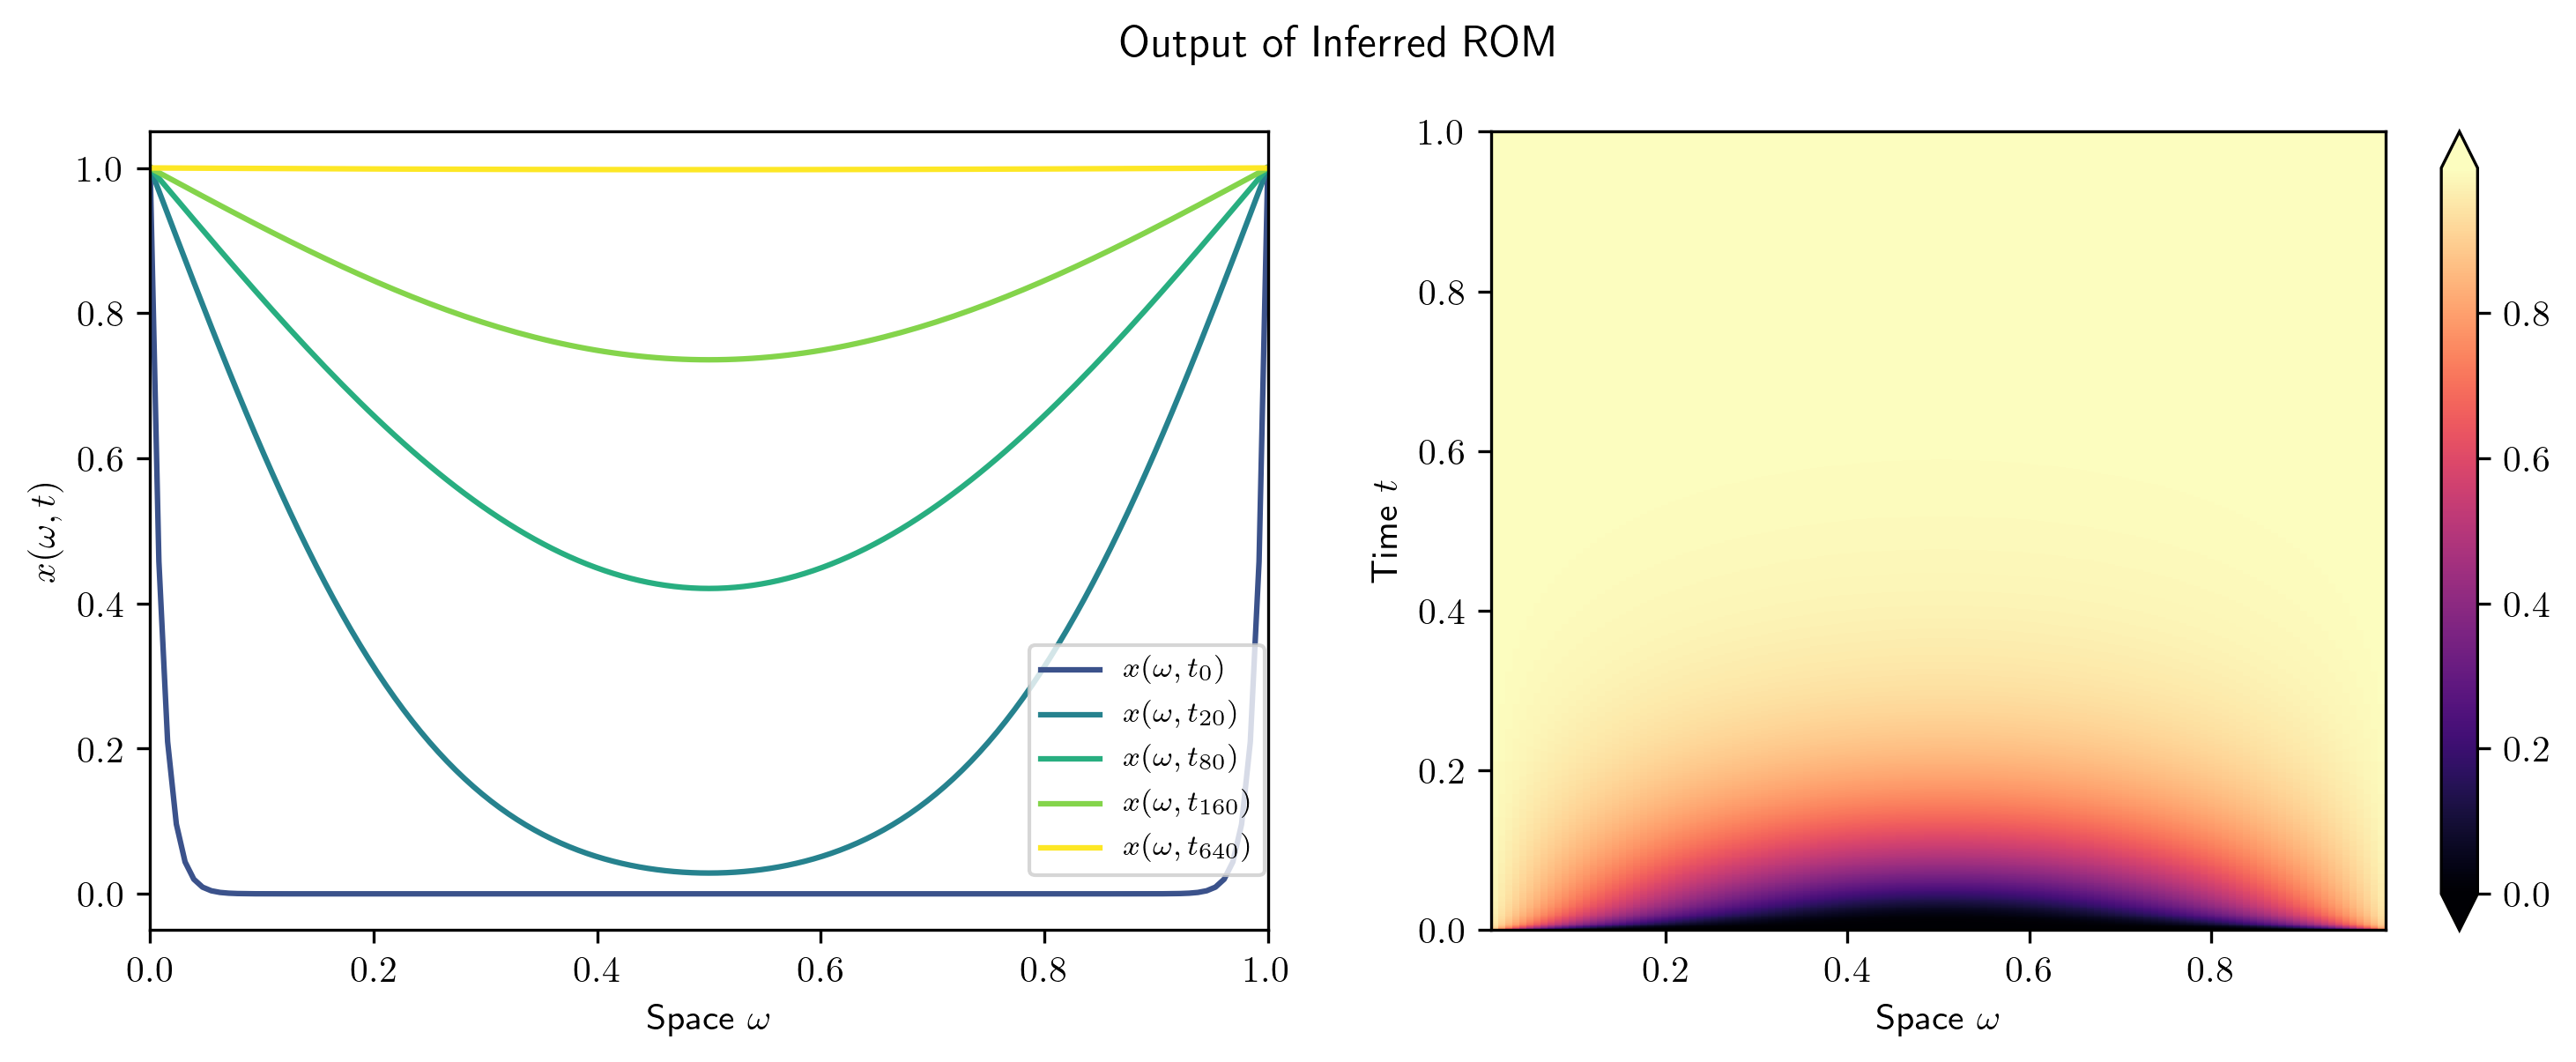

In [13]:
plot_heat_data(X_ROM_inferred, "Output of Inferred ROM")

We can also check how well we did relative to the projection error.

In [14]:
relative_projection_error = roi.post.lp_error(X, Vr @ Vr.T @ X, normalize=True)[1]

def plot_relative_errors_over_time(Zlist, labels):
    colors = ["C0", "C3"]
    plt.semilogy(t, relative_projection_error, "C1", label="Projection Error")
    for Z,label,c in zip(Zlist, labels, colors[:len(Zlist)]):
        relative_l2_error = roi.post.lp_error(X, Z, normalize=True)[1]
        plt.semilogy(t, relative_l2_error, c, label=label)

    plt.xlabel(r"Time $t$")
    plt.legend(loc="upper right")
    plt.title(r"Relative $\ell^2$ Error in Time")
    plt.show()

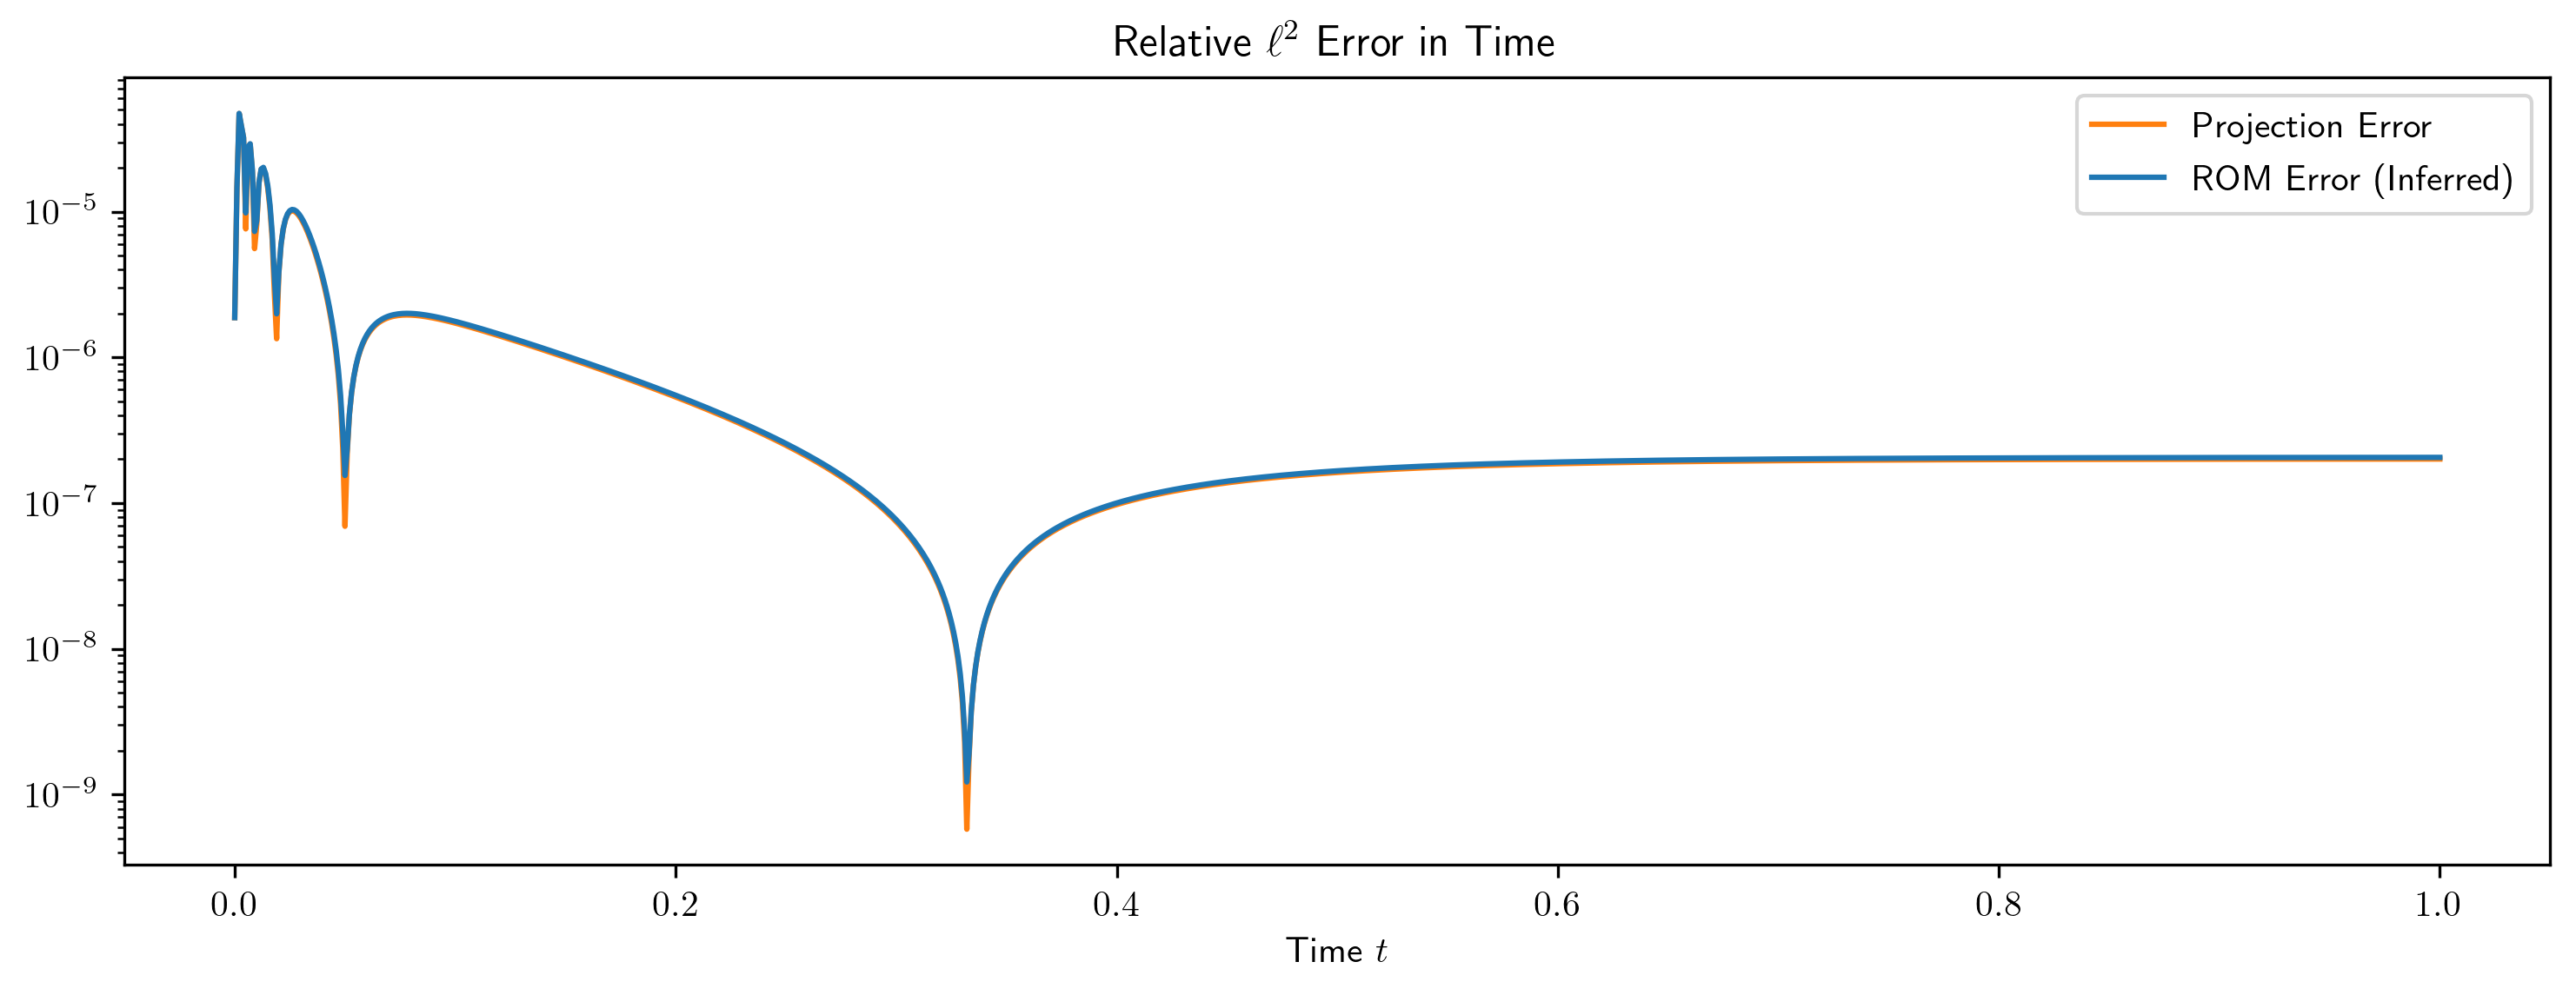

In [15]:
plot_relative_errors_over_time([X_ROM_inferred], ["ROM Error (Inferred)"])

### Comparison with Intrusive Methods

Under some idealized assumptions, the operators learned through operator inference "converge" in a sense to the corresponding operators obtained through intrusive projection,
$$
\begin{align*}
    \tilde{A} &= V_{r}^\mathsf{T} A V_{r}^\mathsf{T},
    &
    \tilde{B} &= V_{r}^\mathsf{T}B.
\end{align*}
$$
We construct the (intrusive) reduced model corresponding to these projected reduced operators for comparison.

In [16]:
intrusive_model = roi.IntrusiveContinuousROM("AB")
intrusive_model.fit({"A":A, "B":B}, Vr)
X_ROM_intrusive = Vr @ implicit_euler(t, x0_, intrusive_model.A_, intrusive_model.B_, U)

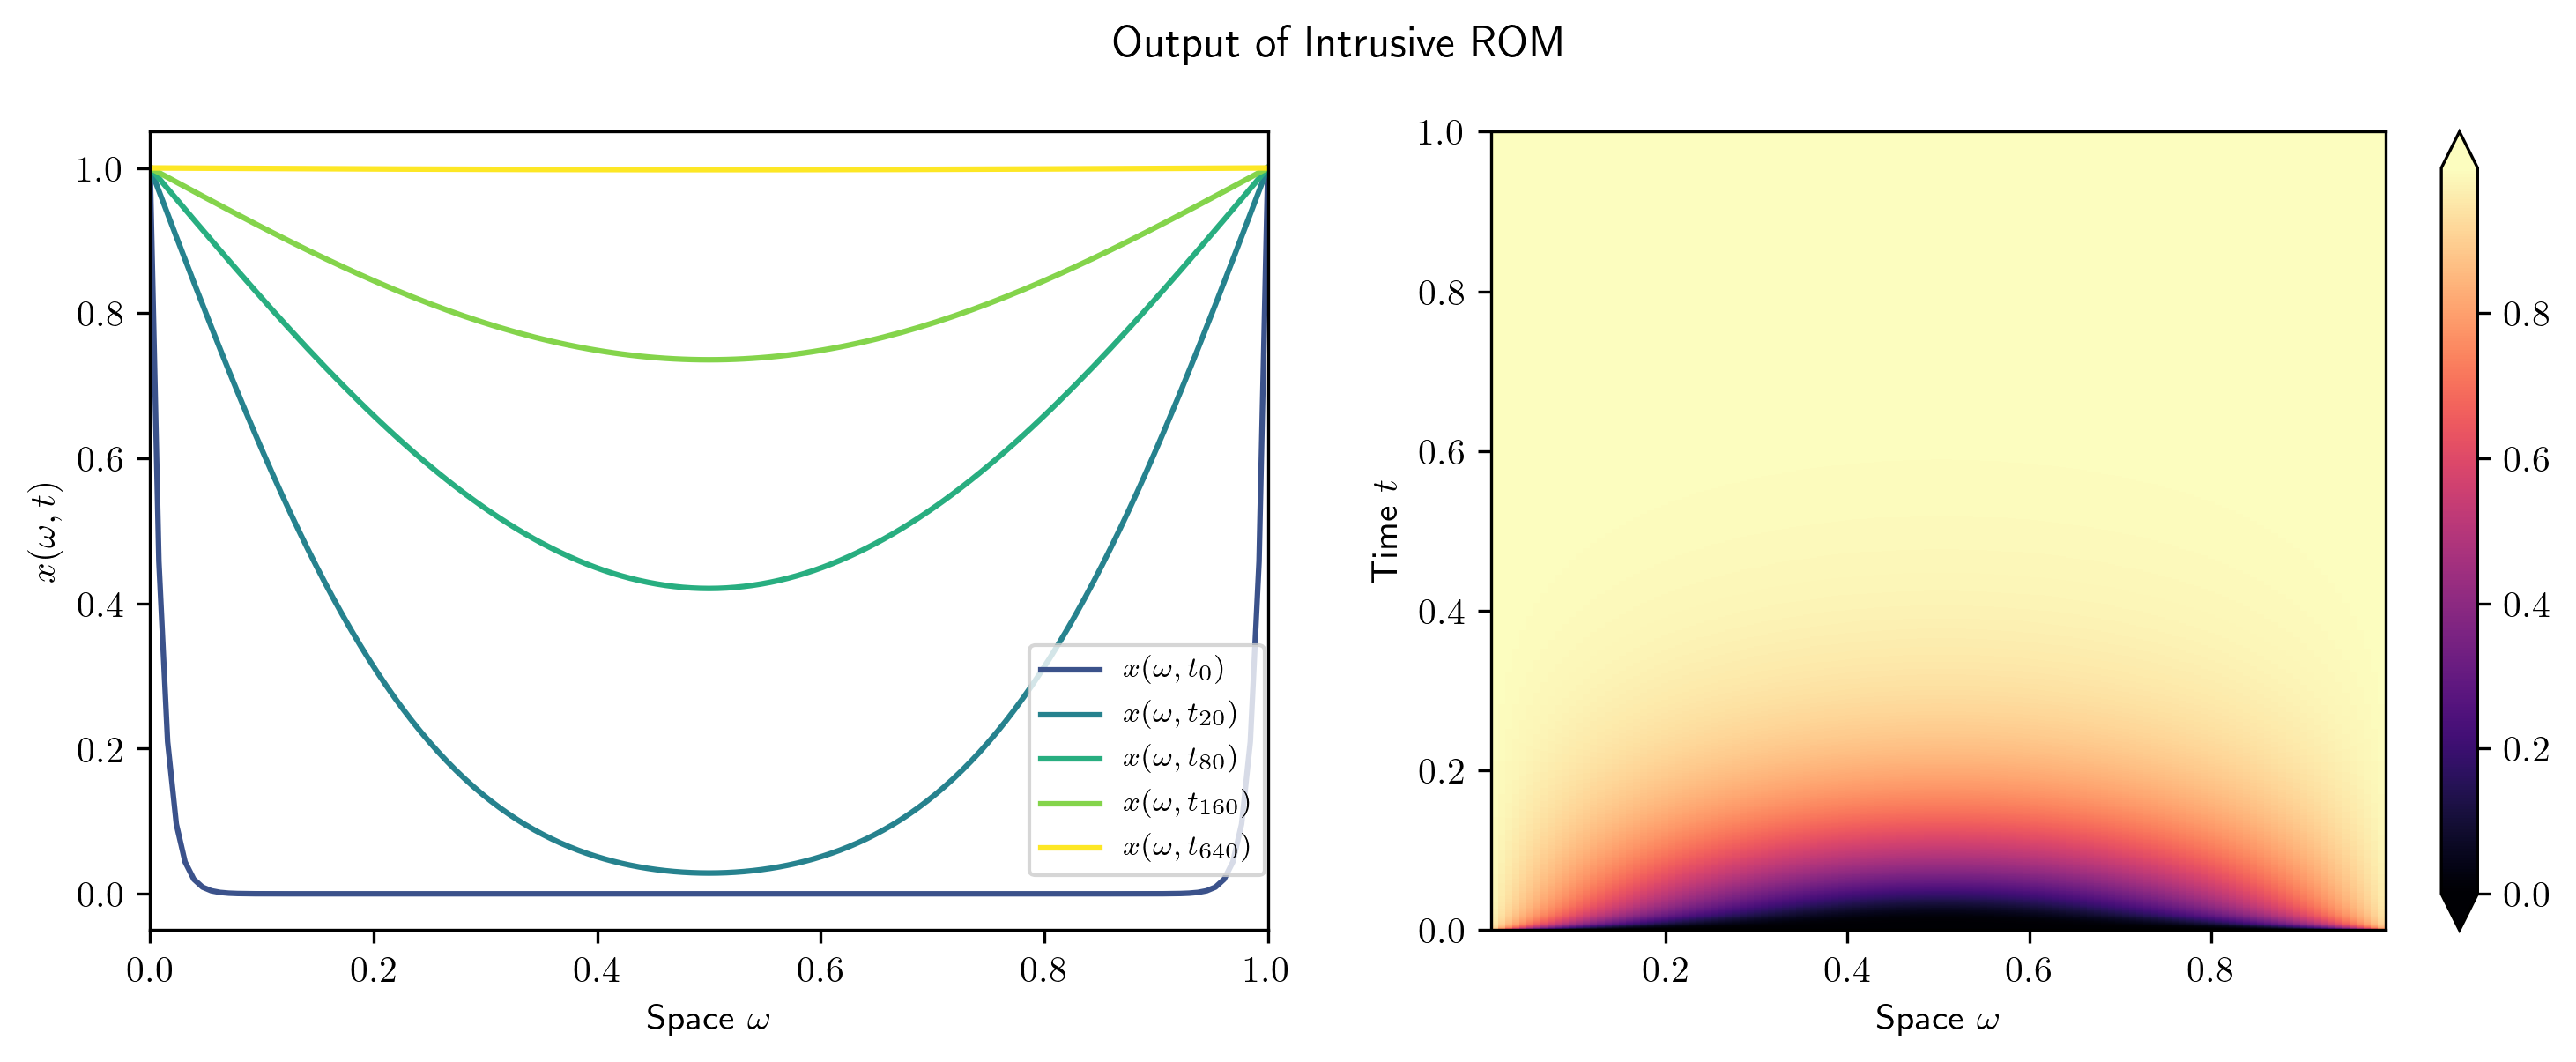

In [17]:
plot_heat_data(X_ROM_intrusive, "Output of Intrusive ROM")

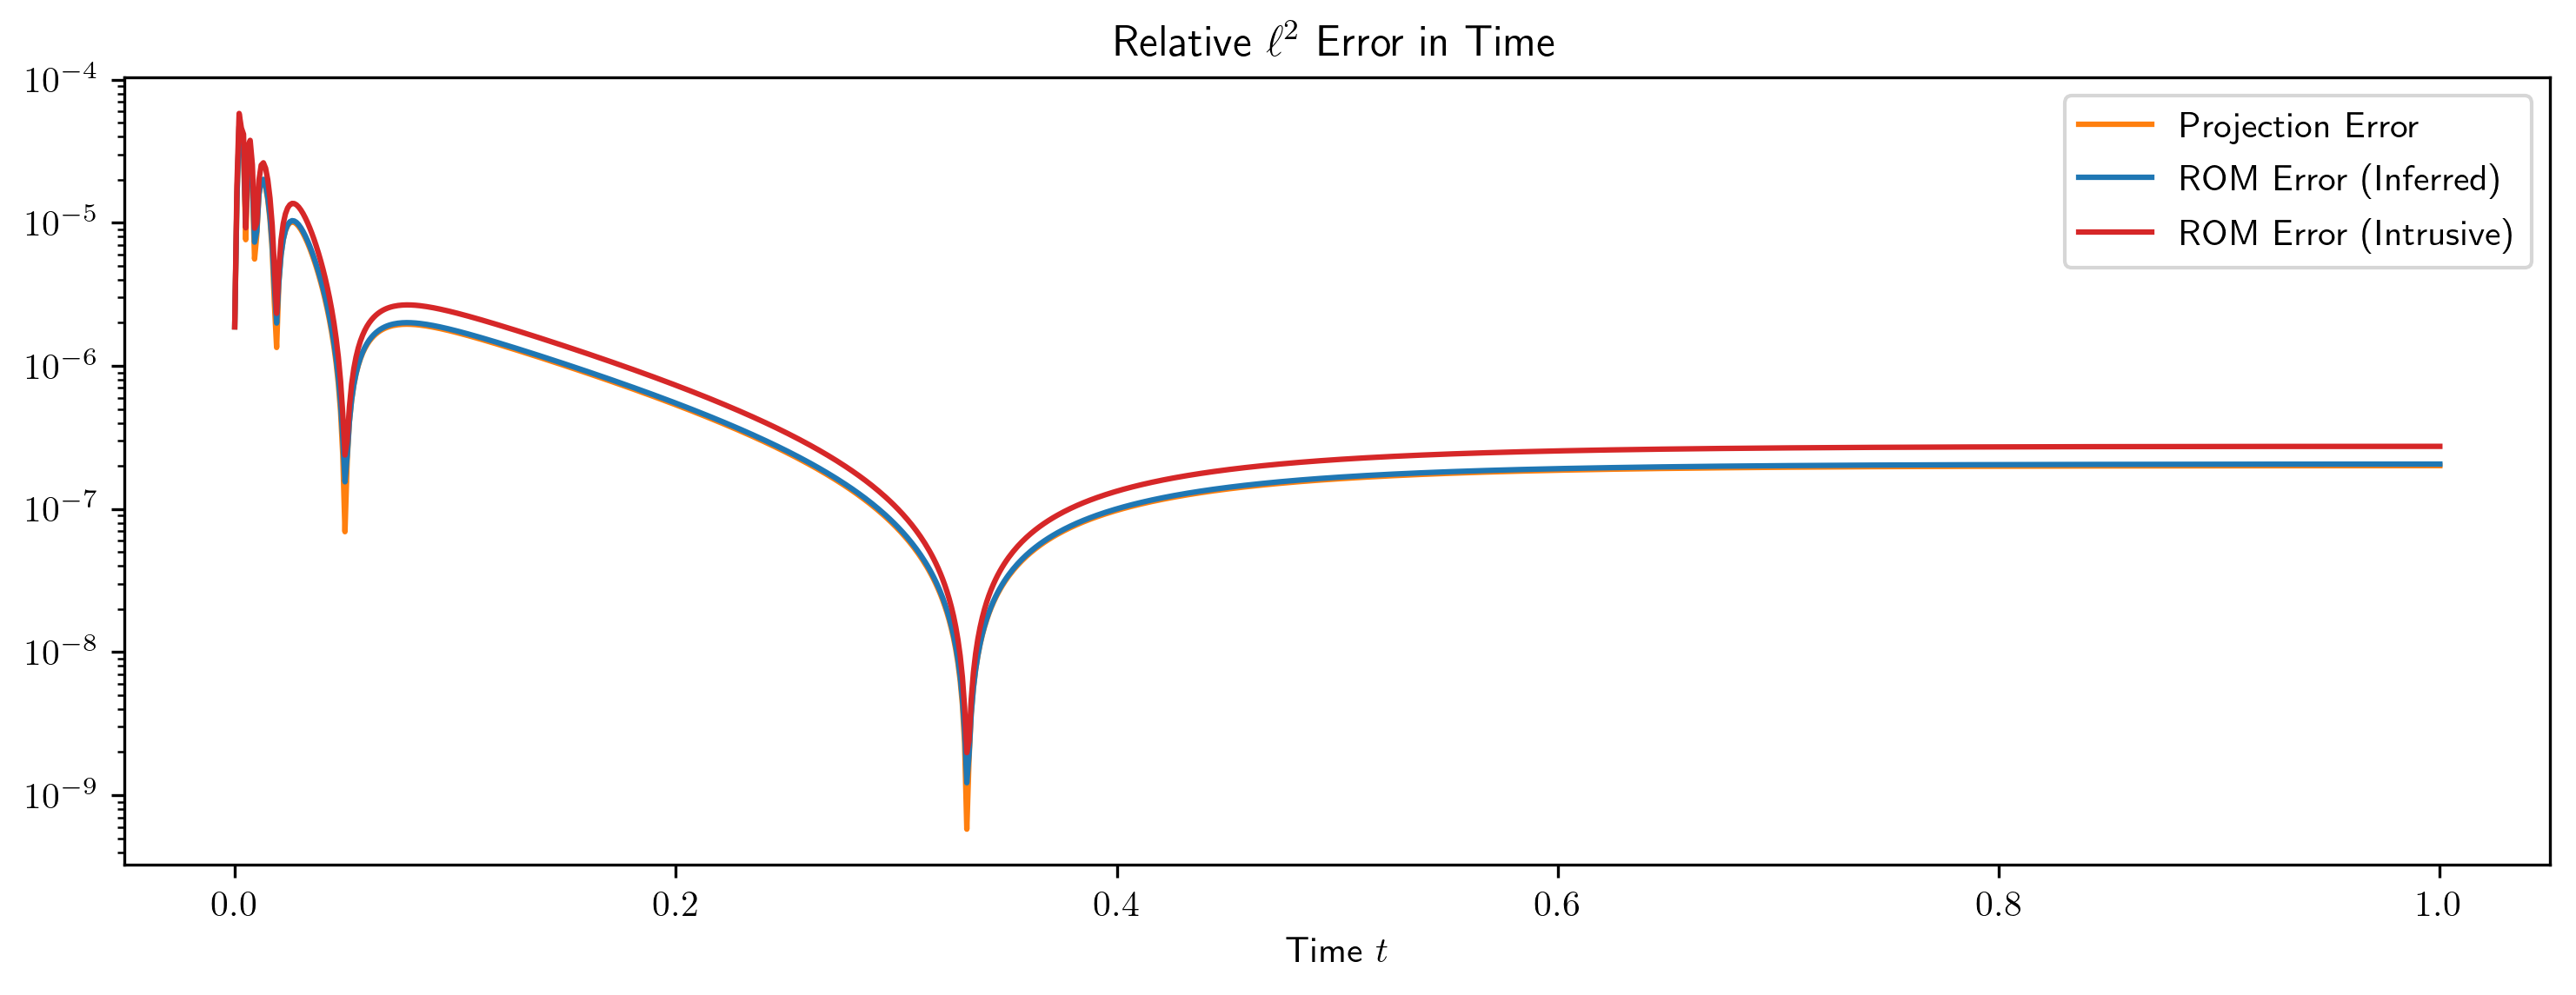

In [18]:
plot_relative_errors_over_time([X_ROM_inferred, X_ROM_intrusive],
                               ["ROM Error (Inferred)", "ROM Error (Intrusive)"])

In [19]:
la.norm(X_ROM_intrusive - X_ROM_inferred) / la.norm(X_ROM_intrusive)

2.603827921269772e-06

In this case, **the inferred and projected ROMs give essentially the same result**.
However, the inferred ROM successfully emulates the FOM **without explicit knowledge of the operators** $A$ **and** $B$.

Before moving forward, let's see how the dimension $r$ affects the accuracy of the ROM.

In [20]:
def run_trial(r):
    Vr = roi.pre.pod_basis(X, r)
    
    # Construct and simulate the intrusive ROM.
    intrusive_model = roi.IntrusiveContinuousROM("AB").fit({"A":A, "B":B}, Vr[:,:r])
    X_ROM_intrusive = Vr @ implicit_euler(t, Vr.T @ x0,
                                          intrusive_model.A_, intrusive_model.B_, U)

    # Construct and simulate the inferred ROM.
    inferred_model = roi.InferredContinuousROM("AB").fit(X, Xdot, Vr[:,:r], U)
    X_ROM_inferred = Vr @ implicit_euler(t, Vr.T @ x0,
                                         inferred_model.A_, inferred_model.B_, U)
    
    # Calculate errors.
    projection_error = roi.pre.projection_error(X, Vr)
    intrusive_error = roi.post.frobenius_error(X, X_ROM_intrusive)[1]
    inference_error = roi.post.frobenius_error(X, X_ROM_inferred)[1]
    
    return projection_error, intrusive_error, inference_error

In [21]:
def plot_state_error(rmax):
    rs = np.arange(1, rmax+1)
    err_projection, err_intrusive, err_inference = zip(*[run_trial(r) for r in rs])

    plt.semilogy(rs, err_projection, 'C1-', label="projection error")
    plt.semilogy(rs, err_intrusive, 'C3+-', label="intrusive", mew=2)
    plt.semilogy(rs, err_inference, 'C0o-', label="inference-based", mfc='none', mec='C0', mew=1.5)
    
    plt.xlim(rs.min(), rs.max())
    plt.xticks(rs, [str(int(r)) for r in rs])
    plt.xlabel(r"dimension $r$")
    plt.ylabel(r"state error")
    plt.legend(loc="upper right", fontsize=18, shadow=True, framealpha=1)
    plt.grid(ls=':')
    plt.title("Errors for Non-parametric problem")
    plt.show()

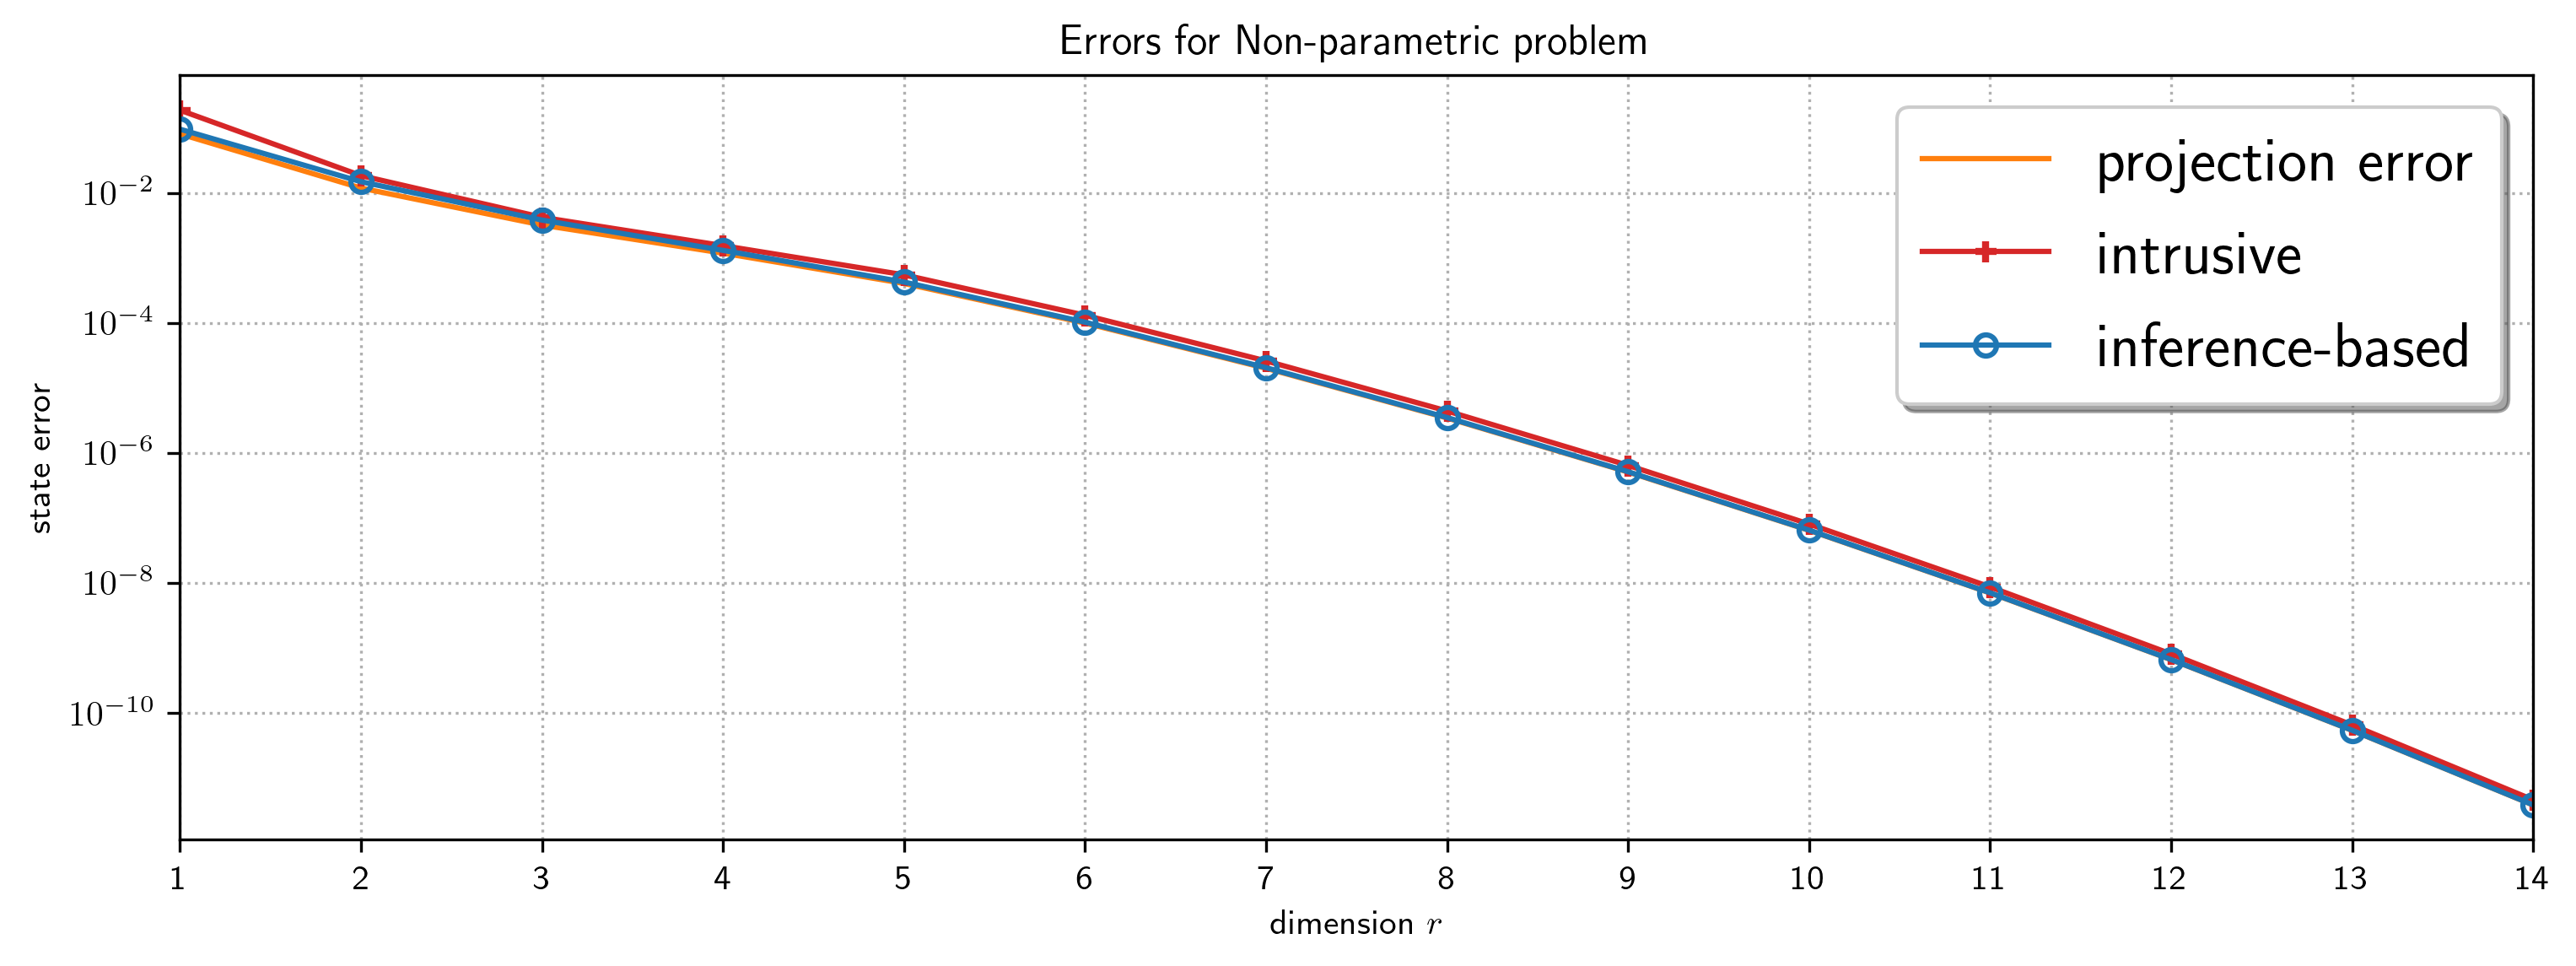

In [22]:
plot_state_error(14)

For this problem, operator inference fits the snapshot data better than the model obtained through intrusive projection for $r < 15$.

## The Parametric Setting

We now extend our problem to allow for different heat conductivities.
Consider the parameter domain $\mathcal{D} = [0.1,10]\subset\mathbb{R}$ with variable $\mu$.
We examine the parametrized heat equation

$$
\begin{align*}
    \frac{\partial}{\partial t} x(\omega,t;\mu) - \mu\frac{\partial^2}{\partial\omega^2}x(\omega,t;\mu) &= 0
    & \omega &\in\Omega,\quad t\in[0,T],
    \\
    x(0,t;\mu) = x(1,t;\mu) &= u(t)
    & t &\in[0,T],
    \\
    x(\omega,0;\mu) = e^{\alpha(\omega - 1)} + e^{-\alpha\omega} &- e^{-\alpha}
    & \omega &\in \Omega.
\end{align*}
$$

Previously, we solved this problem for $\mu = 1$.
To construct a model for any $\mu\in\mathcal{D}$, we take logarithmically spaced samples $\{\mu_i\}_{i=1}^{s}\subset\mathcal{D}$ and let $X(\mu_1$), ..., $X(\mu_{s})$ be the corresponding snapshots computed for each sampled parameter value.
We then contruct a (global) POD basis so that the average projection error,
$$
    \text{err}_\text{projection} = \frac{1}{s}\sum_{i=1}^{s}\frac{||X(\mu_i) - V_r V_r^\mathsf{T}X(\mu_i)||_F}{||X(\mu_i)||_F},
$$
is about $10^{-5}$.
We choose $s = 10$ in the experiment.

The numerical setup is almost identical to the previous problem, except that the semi-discrete linear system is scaled by $\mu$:
$$
   \frac{d}{dt}\mathbf{x}(t;\mu) = \mu A\mathbf{x}(t;\mu) + \mu B u(t).
$$

In [23]:
s = 10                          # Number of parameter samples.
r = 8                           # Dimension of reduced-order model.
µs = np.logspace(-1, 1, s)      # Get s logarithmically spaced values of µ from D = [.1, 10]. 

# Gather snapshot data for each parameter value by running the FOM for each µ.
Xs, Xdots, Us = [], [], []
for µ in µs:
    Aµ, Bµ = µ * A, µ * B
    Xµ = implicit_euler(t, x0, Aµ, Bµ, U)
    Xdotµ = Aµ @ Xµ + Bµ.reshape((-1,1)) * U
    Xs.append(Xµ)
    Xdots.append(Xdotµ)
    Us.append(U)

# Compute the POD basis of rank r using snapshot data from all parameter samples.
Vr = roi.pre.pod_basis(np.hstack(Xs), r)

# Compute the resulting projection error.
total_relative_projection_error = 0
for X in Xs:
    total_relative_projection_error += roi.pre.projection_error(X, Vr)
average_relative_projection_error = total_relative_projection_error / len(Xs)

print(average_relative_projection_error)

2.6379359479425877e-05


Our strategy to account for the parameter $\mu$ is to learn a separate reduced model for each sampled $\mu_i$, $i=1,\ldots,s$.
Then, for a new parameter value $\tilde{\mu}\in\mathcal{D}$, we interpolate the entries of the learned reduced model operators to create a new reduced model corresponding to $\tilde{\mu}\in\mathcal{D}$.
The `InterpolatedInferredContinuousROM` class encapsulates this process.

In [24]:
# Learn reduced models for each parameter value.
pmodel = roi.InterpolatedInferredContinuousROM("AB").fit(µs, Xs, Xdots, Vr, Us)

We begin by evaluating the interpolated model at the parameter samples (i.e. the training data) and computing the average Frobenius error,

$$
\frac{1}{s}\sum_{i=1}^s\frac{||X(\mu_i) - X_\text{ROM}(\mu_i)||_F}{||X(\mu_i)||_F}.
$$

In [25]:
total_error = 0
for i,µ in enumerate(µs):
    X_ROM_µi = Vr @ implicit_euler(t, x0_, pmodel.A_(µ), pmodel.B_(µ), U)
    total_error += roi.post.frobenius_error(Xs[i], X_ROM_µi)[1]
average_error = total_error / len(µs)
average_error

0.000418227437481744

The error is greater than the projection error by an order of magnitude, but it's not bad for a parametric problem.

Next, we compare the inferred ROM with the corresponding intrusive ROMs, varying the reduced dimension $r$.
We run experiments for the training parameters $\{\mu_i\}_{i=1}^s$ and for $5$ other parameters $\mu\in\mathcal{D}$.

In [26]:
V = roi.pre.pod_basis(np.hstack(Xs), 30)

def run_parametric_trial(vals, r):
    Vr = V[:,:r]

    inference_error, intrusive_error, projection_error = 0, 0, 0
    for v in vals:
        # Solve the FOM at this parameter value.
        Xv = implicit_euler(t, x0, v*A, v*B, U)
        
        # Construct and simulate the intrusive ROM.
        intrusive_model = roi.IntrusiveContinuousROM("AB").fit({"A":v*A, "B":v*B}, Vr)
        X_ROM_intrusive = Vr @ implicit_euler(t, Vr.T @ x0,
                                              intrusive_model.A_, intrusive_model.B_, U)

        # Construct and simulate the inferred ROM.
        inferred_pmodel = roi.InterpolatedInferredContinuousROM("AB").fit(µs, Xs, Xdots, Vr, Us)
        X_ROM_inferred = Vr @ implicit_euler(t, Vr.T @ x0,
                                             inferred_pmodel.A_(v), inferred_pmodel.B_(v), U)
        
        # Calculate errors.
        projection_error += roi.pre.projection_error(Xv, Vr)
        intrusive_error += roi.post.frobenius_error(Xv, X_ROM_intrusive)[1]
        inference_error += roi.post.frobenius_error(Xv, X_ROM_inferred)[1]
    
    trials = len(vals)
    return projection_error / trials, intrusive_error / trials, inference_error / trials

In [27]:
def plot_average_state_error(rmax, vals):
    rs = np.arange(1, rmax+1)
    err_projection, err_intrusive, err_inference = zip(*[run_parametric_trial(vals, r) for r in rs])

    plt.semilogy(rs, err_projection, 'C1-', label="projection error")
    plt.semilogy(rs, err_intrusive, 'C3+-', label="intrusive", mew=2)
    plt.semilogy(rs, err_inference, 'C0o-', label="inference-based", mfc='none', mec='C0', mew=1.5)

    plt.xlim(rs.min(), rs.max())
    plt.xticks(rs, [str(int(r)) for r in rs])
    plt.xlabel(r"dimension $r$")
    plt.ylabel(r"average state error")
    plt.legend(loc="upper right", fontsize=18, shadow=True, framealpha=1)
    plt.grid(ls=':')
    plt.title("Errors for parametric problem")
    plt.show()

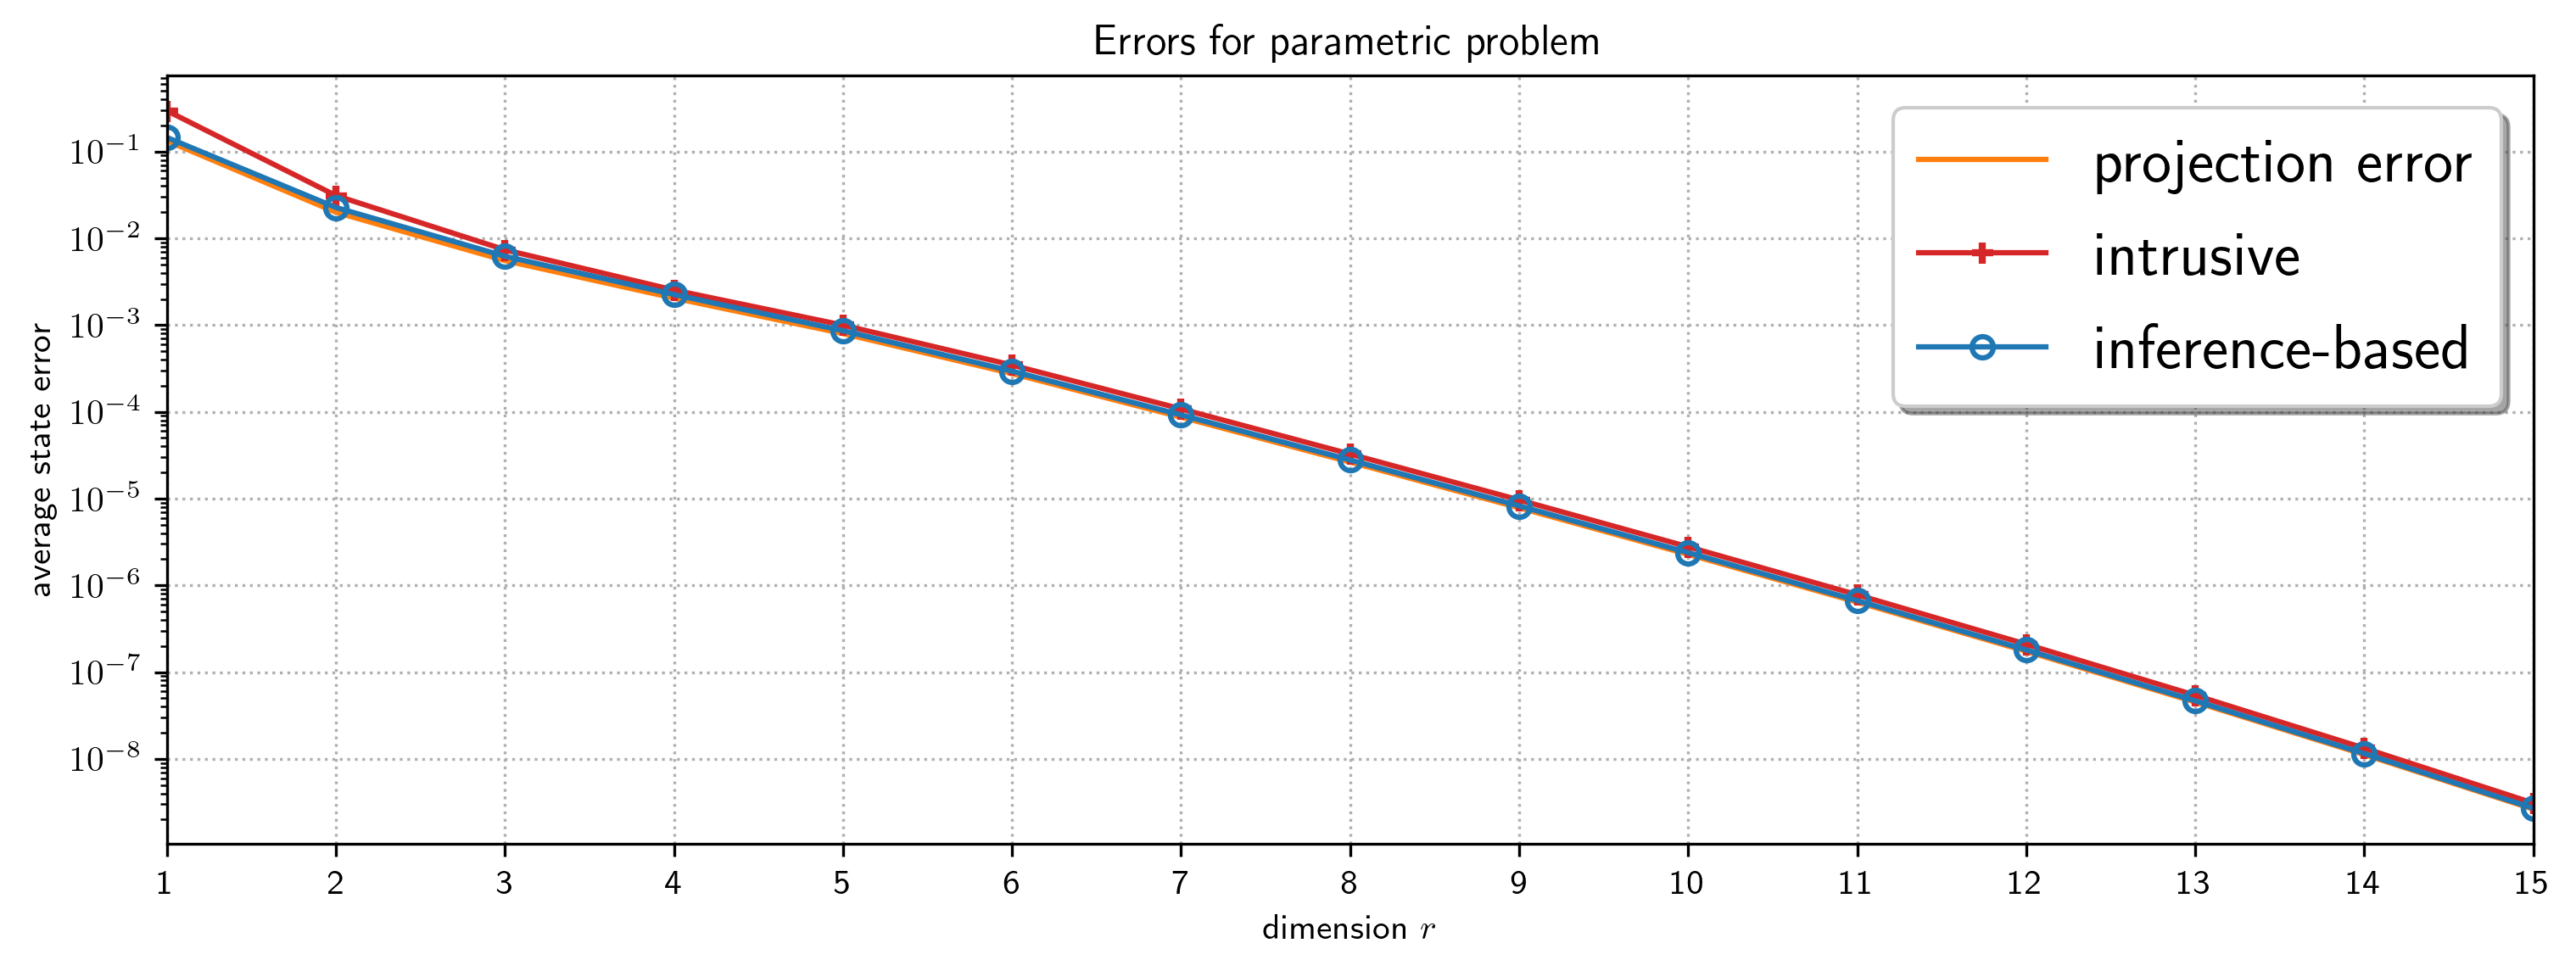

In [28]:
plot_average_state_error(15, µs)

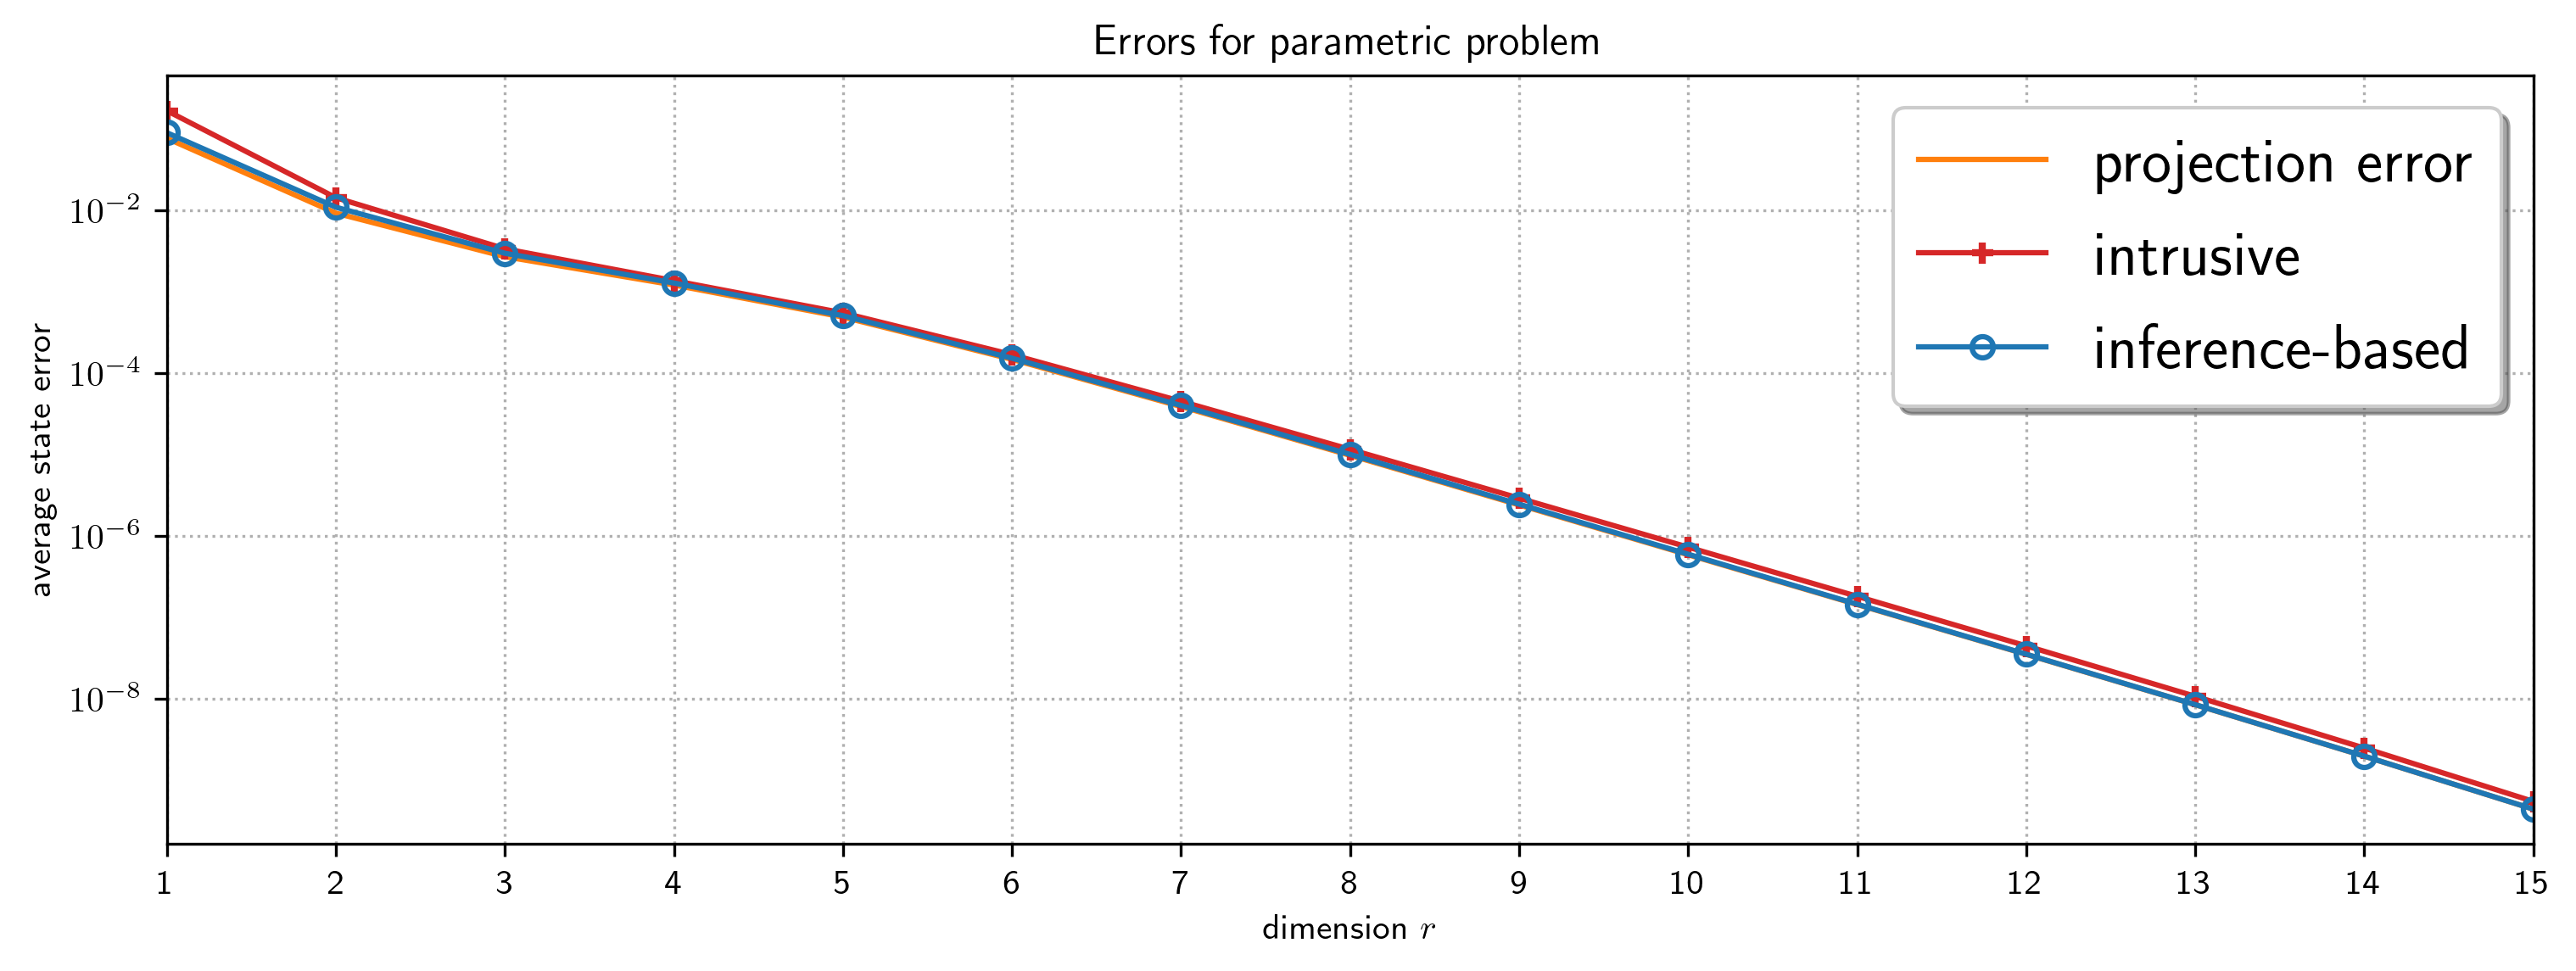

In [29]:
plot_average_state_error(15, np.random.uniform(.1, 10, 5))